# Assignment 1

**Course** CS-867 Computer Vision

**Instructor:** Dr. Muhammad Moazam Fraz

**Submitted By:** Sarfraz Ahmad

**CMS ID:** 363320


## Importing Libraries

In [128]:
import os
import random
import pandas as pd
import numpy as np
import cv2
import time
from tqdm import tqdm
from cv2 import HOGDescriptor

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut, cross_validate, cross_val_score, StratifiedShuffleSplit

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

## Load and View Images

In [129]:
folders = os.listdir("CS67_Fall2022_ A1_Dataset")
if ".DS_Store" in folders:
    folders.remove(".DS_Store")

folders = sorted(folders, key=int)

data_type = ["train", "test"] # txt Files in Dataset folders
df_list = [] # List that will contain the dataframe dict

# In each folder there are 2 txt files, train.txt and test.txt
# train.txt files from each folder are taken and image names in these files are stored as filename in dict
# Same procedure is then followed for test.txt files
for i in data_type: 
    for j in folders:
        with open(f"CS67_Fall2022_ A1_Dataset/{j}/{i}.txt") as f:
            for line in f:
                df_dict = {}
                df_dict["folder"] = j 
                df_dict["filename"] = line
                df_dict["file_type"] = i    # Train or Test
                df_dict["file_path"] = f"CS67_Fall2022_ A1_Dataset/{j}/{line}".strip()
                df_dict["label"] = int(j)   # Integer Label
                df_list.append(df_dict)

df = pd.DataFrame.from_dict(df_list)
df.head(10)

,folder,filename,file_type,file_path,label
0,00001,00468_00002.ppm\n,train,CS67_Fall2022_ A1_Dataset/00001/00468_00002.ppm,1
1,00001,00475_00000.ppm\n,train,CS67_Fall2022_ A1_Dataset/00001/00475_00000.ppm,1
2,00001,00475_00001.ppm\n,train,CS67_Fall2022_ A1_Dataset/00001/00475_00001.ppm,1
3,00001,00475_00002.ppm\n,train,CS67_Fall2022_ A1_Dataset/00001/00475_00002.ppm,1
4,00001,00801_00000.ppm\n,train,CS67_Fall2022_ A1_Dataset/00001/00801_00000.ppm,1
5,00001,00801_00001.ppm\n,train,CS67_Fall2022_ A1_Dataset/00001/00801_00001.ppm,1
6,00001,00801_00002.ppm\n,train,CS67_Fall2022_ A1_Dataset/00001/00801_00002.ppm,1
7,00001,00806_00000.ppm\n,train,CS67_Fall2022_ A1_Dataset/00001/00806_00000.ppm,1
8,00001,00806_00001.ppm\n,train,CS67_Fall2022_ A1_Dataset/00001/00806_00001.ppm,1
9,00001,00806_00002.ppm\n,train,CS67_Fall2022_ A1_Dataset/00001/00806_00002.ppm,1


In [130]:
# Initialize lists to store train and test images
X_train = []
y_train = []
X_test = []
y_test = []

# iterate over the dataframe rows. For each row check type of file that whether it is train or test.
for _, row in tqdm(df.iterrows(), total=df.shape[0]):
    if row.file_type == "train":
        img = cv2.imread(row.file_path) # Read the file using filepath given in dataframe.
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Convert to grayscale
        img = cv2.resize(img, (128, 128))
        X_train.append(img) # Append the loaded image in training data list 
        y_train.append(row.label)
    else:
        img = cv2.imread(row.file_path) # Read the file using filepath given in dataframe.
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Convert to grayscale
        img = cv2.resize(img, (128, 128))
        X_test.append(img) # Append the loaded image in test data list
        y_test.append(row.label)

# Convert train and test data to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)

print("Training Set Shape: ", X_train.shape)
print("Test Set Shape: ", X_test.shape)

100%|██████████| 1000/1000 [00:00<00:00, 3085.15it/s]

Training Set Shape:  (800, 128, 128)
Test Set Shape:  (200, 128, 128)


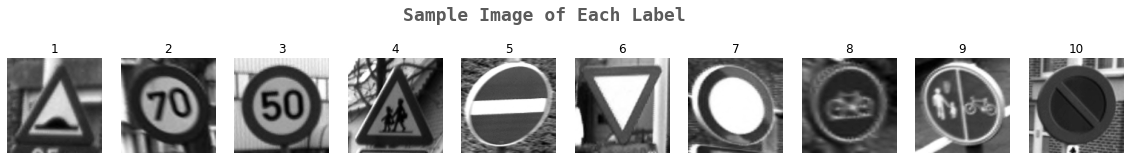

In [131]:
# Visiualize 1 image from each of the class

k=0
fig, ax = plt.subplots(1,10,figsize=(20,10))    # Grid of images
fig.text(s='Sample Image of Each Label',size=18,fontweight='bold',
             fontname='monospace',color='#313131',y=0.62,x=0.4,alpha=0.8)
for i in df["label"].unique():  # unique labels are used to visiualize images
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j], 'gray')
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

## SIFT Descriptor and Helper Functions

In [122]:
def getDescriptors(sift, img):
    kp, des = sift.detectAndCompute(img, None)
    return des

def vstackDescriptors(descriptor_list):
    descriptors = np.array(descriptor_list[0])
    for descriptor in descriptor_list[1:]:
        descriptors = np.vstack((descriptors, descriptor)) 

    return descriptors

def clusterDescriptors(descriptors, no_clusters):
    kmeans = KMeans(n_clusters = no_clusters).fit(descriptors)
    return kmeans

def extractFeatures(kmeans, descriptor_list, image_count, no_clusters):
    im_features = np.array([np.zeros(no_clusters) for i in range(image_count)])
    for i in range(image_count):
        for j in range(len(descriptor_list[i])):
            feature = descriptor_list[i][j]
            feature = feature.reshape(1, 128)
            idx = kmeans.predict(feature)
            im_features[i][idx] += 1

    return im_features

def normalizeFeatures(scale, features):
    return scale.transform(features)

def plotHistogram(im_features, no_clusters):
    x_scalar = np.arange(no_clusters)
    y_scalar = np.array([abs(np.sum(im_features[:,h], dtype=np.int32)) for h in range(no_clusters)])

    plt.figure(figsize=(20,10))
    plt.bar(x_scalar, y_scalar)
    plt.xlabel("Visual Word Index")
    plt.ylabel("Frequency")
    plt.title("Complete Vocabulary Generated")
    plt.xticks(x_scalar + 0.4, x_scalar)
    plt.show()

def svcParamSelection(X, y, kernel, nfolds):
    Cs = [0.1, 1, 10, 100]
    gammas = [0.1, 0.11, 0.095, 0.105]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(SVC(kernel=kernel), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

def findSVM(im_features, train_labels, kernel):
    features = im_features
    if kernel == "precomputed":
      features = np.dot(im_features, im_features.T)
    
    params = svcParamSelection(features, train_labels, kernel, 5)
    C_param, gamma_param = params.get("C"), params.get("gamma")
    print(C_param, gamma_param)
  
    svm = SVC(kernel = kernel, C =  C_param, gamma = gamma_param)
    svm.fit(features, train_labels)
    return svm

## SVM with SIFT

### Training

In [123]:
def trainModel(trainingData, trainLabels, no_clusters, kernel):
    sift = cv2.SIFT_create()
    descriptor_list = []
    train_labels = trainLabels
    label_count = 10
    image_count = X_train.shape[0]

    for img in trainingData:
        des = getDescriptors(sift, img)
        descriptor_list.append(des)

    descriptors = vstackDescriptors(descriptor_list)
    print("Descriptors vstacked.")

    kmeans = clusterDescriptors(descriptors, no_clusters)
    print("Descriptors clustered.")

    im_features = extractFeatures(kmeans, descriptor_list, image_count, no_clusters)
    print("Images features extracted.")

    scale = StandardScaler().fit(im_features)        
    im_features = scale.transform(im_features)
    print("Train images normalized.")

    plotHistogram(im_features, no_clusters)
    print("Features histogram plotted.")

    svm = findSVM(im_features, train_labels, kernel)
    print("SVM fitted.")
    print("Training completed.")

    return kmeans, scale, svm, im_features

Descriptors vstacked.
Descriptors clustered.
Images features extracted.
Train images normalized.


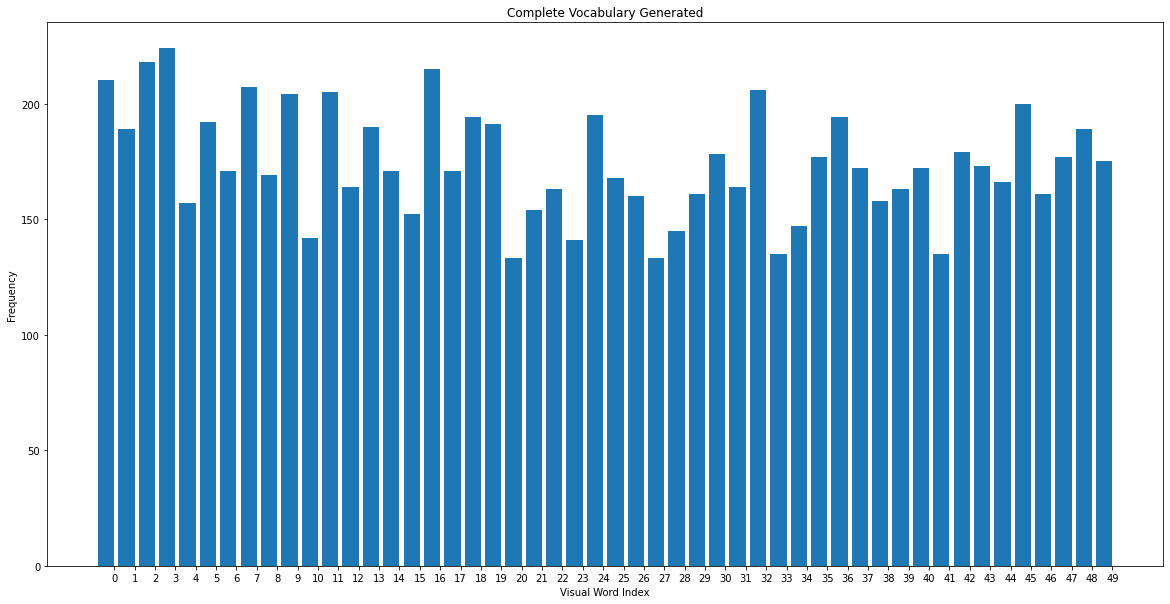

Features histogram plotted.
0.1 0.1
SVM fitted.
Training completed.
--- 37.52240777015686 seconds ---


In [124]:
#train_path = "inputs/dataset/train"
#test_path = "inputs/dataset/test"
no_clusters = 50
kernel = "precomputed"

start_time = time.time()
kmeans, scale, svm, im_features = trainModel(X_train, y_train, no_clusters, kernel)
print("--- %s seconds ---" % (time.time() - start_time))


### Testing SVM

In [125]:
def testModel(testData, kmeans, scale, svm, im_features, no_clusters, kernel):
    count = 0
    true = []
    descriptor_list = []

    sift = cv2.SIFT_create()

    for img in testData:
        des = getDescriptors(sift, img)

        if des is not None:
            count += 1
            descriptor_list.append(des)

    descriptors = vstackDescriptors(descriptor_list)

    test_features = extractFeatures(kmeans, descriptor_list, count, no_clusters)

    test_features = scale.transform(test_features)
    
    kernel_test = test_features
    if kernel == "precomputed":
        kernel_test = np.dot(test_features, im_features.T)
    
    predictions = svm.predict(kernel_test)
    print("Test images classified.")

    return predictions

In [126]:
start_time = time.time()
y_pred = testModel(X_test, kmeans, scale, svm, im_features, no_clusters, kernel)
print("--- %s seconds ---" % (time.time() - start_time))

Test images classified.
--- 4.098567962646484 seconds ---


## Results

### Quantitative Results

              precision    recall  f1-score   support

           1       0.55      0.60      0.57        20
           2       0.77      0.85      0.81        20
           3       0.82      0.70      0.76        20
           4       0.83      0.95      0.88        20
           5       0.77      0.85      0.81        20
           6       0.50      0.40      0.44        20
           7       0.58      0.55      0.56        20
           8       0.95      0.95      0.95        20
           9       1.00      0.85      0.92        20
          10       0.68      0.75      0.71        20

    accuracy                           0.74       200
   macro avg       0.75      0.74      0.74       200
weighted avg       0.75      0.74      0.74       200



Text(33.0, 0.5, 'Actual Class')

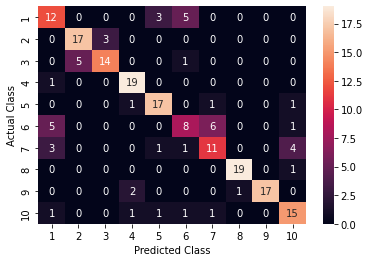

In [165]:
print(classification_report(y_test, y_pred))

x_axis_labels = sorted(np.unique(y_test)) # labels for x-axis
y_axis_labels = sorted(np.unique(y_test)) # labels for y-axis

sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")

### Qualitative Results

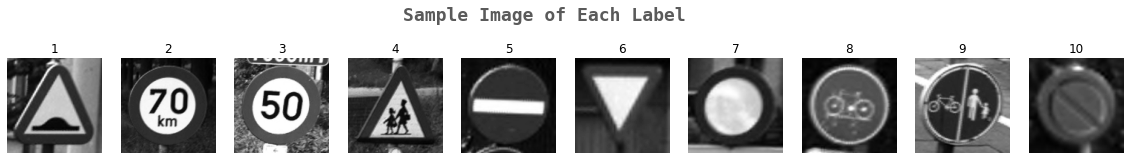

In [160]:
# Correctly Classified Test Images from each class
k=0
fig, ax = plt.subplots(1,10,figsize=(20,10))    # Grid of images
fig.text(s='Sample Image of Each Label',size=18,fontweight='bold',
             fontname='monospace',color='#313131',y=0.62,x=0.4,alpha=0.8)
for i in df["label"].unique():  # unique labels are used to visiualize images
    j=0
    while True:
        if y_test[j]==i and y_pred[j]==i:
            ax[k].imshow(X_test[j], 'gray')
            ax[k].set_title(y_pred[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

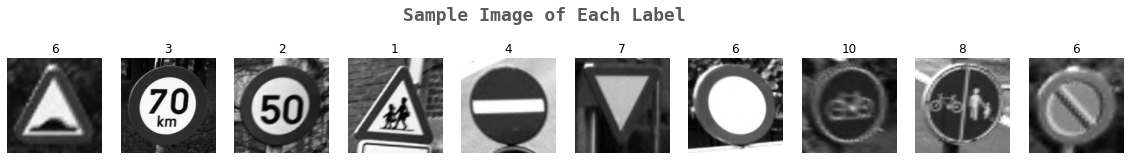

In [163]:
# Incorrectly Classified Test Images from each class
k=0
fig, ax = plt.subplots(1,10,figsize=(20,10))    # Grid of images
fig.text(s='Sample Image of Each Label',size=18,fontweight='bold',
             fontname='monospace',color='#313131',y=0.62,x=0.4,alpha=0.8)
for i in df["label"].unique():  # unique labels are used to visiualize images
    j=0
    while True:
        if y_test[j]==i and y_pred[j]!=i:
            ax[k].imshow(X_test[j], 'gray')
            ax[k].set_title(y_pred[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1